In [1]:
import modules.resnet_3d as resnet
from pathlib import Path
import numpy as np
from modules.mapper import FileMapper as fm
from modules.dataset import Dataset
from modules.dataset_image_only import Dataset as dataset_2
from modules.cnn_model import CNNModel
from torch.utils.data import DataLoader
import torchtuples as tt
from pycox.models import LogisticHazard
import pickle
import random
from modules.mlflow_logger import Logger
from modules.utils import getPatientIdentifier, collate_fn, returnMontage, get_optimizer
import sys
import argparse
import datetime
from pycox.evaluation import EvalSurv
from pycox.utils import kaplan_meier
import logging
import logging.config
import pytz
import torch
import plotly.graph_objs as go
# from lifelines import KaplanMeierFitter
import plotly
plotly.offline.init_notebook_mode(connected=True)
import pandas as pd
%load_ext autoreload
%autoreload 2
import time

In [2]:
# from typing import Tuple
import torch
from torch import Tensor
import torch.nn.functional as F
from pycox.models import utils
from torchtuples import TupleTree


def _reduction(loss: Tensor, reduction: str = 'mean') -> Tensor:
    if reduction == 'none':
        return loss
    elif reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    raise ValueError(f"`reduction` = {reduction} is not valid. Use 'none', 'mean' or 'sum'.")

def nll_logistic_hazard(phi: Tensor, idx_durations: Tensor, events: Tensor,
                        reduction: str = 'mean') -> Tensor:
    """Negative log-likelihood of the discrete time hazard parametrized model LogisticHazard [1].
    
    Arguments:
        phi {torch.tensor} -- Estimates in (-inf, inf), where hazard = sigmoid(phi).
        idx_durations {torch.tensor} -- Event times represented as indices.
        events {torch.tensor} -- Indicator of event (1.) or censoring (0.).
            Same length as 'idx_durations'.
        reduction {string} -- How to reduce the loss.
            'none': No reduction.
            'mean': Mean of tensor.
            'sum: sum.
    
    Returns:
        torch.tensor -- The negative log-likelihood.
    References:
    [1] Håvard Kvamme and Ørnulf Borgan. Continuous and Discrete-Time Survival Prediction
        with Neural Networks. arXiv preprint arXiv:1910.06724, 2019.
        https://arxiv.org/pdf/1910.06724.pdf
    """
    if phi.shape[1] <= idx_durations.max():
        raise ValueError(f"Network output `phi` is too small for `idx_durations`."+
                         f" Need at least `phi.shape[1] = {idx_durations.max().item()+1}`,"+
                         f" but got `phi.shape[1] = {phi.shape[1]}`")
    if events.dtype is torch.bool:
        events = events.float()
    events = events.view(-1, 1)
    events = events.cuda()
    idx_durations = idx_durations.view(-1, 1)
    idx_durations = idx_durations.cuda()
    phi = phi.cuda()
    y_bce = torch.zeros_like(phi).scatter(1, idx_durations, events)
    bce = F.binary_cross_entropy_with_logits(phi, y_bce, reduction='none')
    loss = bce.cumsum(1).gather(1, idx_durations).view(-1)
    return _reduction(loss, reduction)

In [3]:
class _Loss(torch.nn.Module):
    """Generic loss function.
    
    Arguments:
        reduction {string} -- How to reduce the loss.
            'none': No reduction.
            'mean': Mean of tensor.
            'sum: sum.
    """
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

In [4]:
class NLLLogistiHazardLoss(_Loss):
    """Negative log-likelihood of the hazard parametrization model.
    See `loss.nll_logistic_hazard` for details.
    
    Arguments:
        reduction {string} -- How to reduce the loss.
            'none': No reduction.
            'mean': Mean of tensor.
            'sum: sum.
    
    Returns:
        torch.tensor -- The negative log-likelihood.
    """
    def forward(self, phi: Tensor, idx_durations: Tensor, events: Tensor) -> Tensor:
        return nll_logistic_hazard(phi, idx_durations, events, self.reduction)

In [5]:
from torch import Tensor



def output2surv(output: Tensor, epsilon: float = 1e-7) -> Tensor:
    """Transform a network output tensor to discrete survival estimates.
    Ref: LogisticHazard
    """
    hazards = output2hazard(output)
    return hazard2surv(hazards, epsilon)


def hazard2surv(hazard: Tensor, epsilon: float = 1e-7) -> Tensor:
    """Transform discrete hazards to discrete survival estimates.
    Ref: LogisticHazard
    """
    return (1 - hazard).add(epsilon).log().cumsum(1).exp()


def output2hazard(output: Tensor) -> Tensor:
    """Transform a network output tensor to discrete hazards. This just calls the sigmoid function
    Ref: LogisticHazard
    """
    return output.sigmoid()

In [6]:
# from pycox.models.loss import NLLLogistiHazardLoss
# from pycox.models.discrete_time import output2hazard, output2surv

# Create Dataset

In [7]:
preop_patients = []
for path in Path('./data/preoperative_no_norm').glob('BMIAXNA*'):
    preop_patients.append(path)

In [8]:
id_mapping = './data/pickles_jsons/id_surv_mapping_10_groups.json'

In [9]:
mapper_class = fm(preop_patients, id_mapping, normalized=True)
dataset = mapper_class.generate_mapping()

Number of patients/folders: 1016


In [10]:
with open('./data/pickles_jsons/filter_ids_v2_all.pkl', 'rb') as file:
    filter_ids = pickle.load(file)
dataset_filtered = [entry for entry in dataset if entry['ENT'] is not None]
dataset_filtered = [entry for entry in dataset_filtered if entry['id'] not in filter_ids]

## Set Random seed and randomize dataset

In [11]:
random.seed(4)
random.shuffle(dataset_filtered)

In [12]:
dataset_filtered[0]

{'id': 'BMIAXNAT_S99999',
 'T2w': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/T2w/BMIAXNAT_E99999_301_T2w.nii.gz',
 'T1c': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/T1c/BMIAXNAT_E99999_301_T1c.nii.gz',
 'T1w': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/T1w/BMIAXNAT_E99999_301_T1w.nii.gz',
 'ENT': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/ENT/BMIAXNAT_E99999_302-MR1_ENT.nii.gz',
 'FLR': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/FLR/BMIAXNAT_E99999_301_FLR.nii.gz',
 'surv': 29.0,
 'event': 1,
 'group': 1}

# Train/Test/Val split datasets

In [13]:
train_dataset = Dataset(dataset_filtered, phase='train', normalize='zscore', size=64)
val_dataset = Dataset(dataset_filtered, phase='val', normalize='zscore', size=64)

Training Size: 711
Validation Size: 101


In [14]:
test_dataset = dataset_2(dataset_filtered, phase='test', normalize='zscore', size=64)

Test Size: 204


# DataLoaders

In [15]:
train_loader = DataLoader(train_dataset,
                          batch_size=128,
                          num_workers=6,
                          shuffle=False,
                          collate_fn=collate_fn)
val_loader = DataLoader(val_dataset,
                        batch_size=101,
                        num_workers=6, shuffle=False,
                        collate_fn=collate_fn)
test_loader = DataLoader(test_dataset,
                         batch_size=204,
                         shuffle=False)

# ResNet-10

In [16]:
cuts = np.array([   0.,   66.,  141.,  208.,  292.,  363.,  449.,  592.,  829., 1785.])

In [17]:
net = resnet.generate_model(model_depth=10,
                        n_classes=10,
                        n_input_channels=4,
                        shortcut_type='B',
                        conv1_t_size=7,
                        conv1_t_stride=1,
                        no_max_pool=False,
                        widen_factor=1.0)
# net.to(torch.device("cuda:0"))

In [18]:
net.to(torch.device("cuda:0"))

ResNet(
  (conv1): Conv3d(4, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=T

In [19]:
from torch import nn
import copy
import datetime

In [20]:
data_loaders = {'Train': train_loader, 'Val': val_loader}
# data_lengths = {"train": len(train_dataset), "val": len(val_dataset)}

In [21]:
n_epochs = 20

In [22]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
loss_func = NLLLogistiHazardLoss()

best_loss = 1000.0
best_model = net

total_duration = 0

for epoch in range(n_epochs):
    time_begin = time.time()
    running_loss = 0.0
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)
    for i, data in enumerate(train_loader):
        x, (duration, event) = data
        x = x.cuda()
        
        optimizer.zero_grad()
        output = net(x)
        loss = loss_func(output, duration, event)  # need x, duration, event

        # zero the parameter (weight) gradients
        optimizer.zero_grad()
        
        loss.backward()
                
        # update the weights
        optimizer.step()
        
        # Cumulative loss validation
        running_loss += loss.item()
    
    train_loss = copy.deepcopy(running_loss)
    running_loss = 0.0
    
    for j, data in enumerate(val_loader):
        with torch.no_grad():
            x, (duration, event) = data
            x = x.cuda()

            output = net(x)

            loss = loss_func(output, duration, event)  # need x, duration, event

            # Cumulative loss validation
            running_loss += loss.item()
            
            if running_loss < best_loss:
                best_loss = running_loss
                best_model = copy.deepcopy(net)
        
    time_end = time.time()

    total_sec = time_end-time_begin
    total = str(datetime.timedelta(seconds=total_sec))
#     total_duration += total_sec
    
    if j == 0:
        j += 1
    
    print(f'Train loss: {train_loss / i} -- Val loss: {running_loss / j} -- duration: {total}')

Epoch 0/19
----------
Train loss: 3.0653474807739256 -- Val loss: 2.1483428478240967 -- duration: 0:07:26.546926
Epoch 1/19
----------
Train loss: 2.540719223022461 -- Val loss: 2.045602321624756 -- duration: 0:07:28.838712
Epoch 2/19
----------
Train loss: 2.404555344581604 -- Val loss: 2.038055419921875 -- duration: 0:07:25.100639
Epoch 3/19
----------
Train loss: 2.3828145027160645 -- Val loss: 2.013850212097168 -- duration: 0:07:24.511926
Epoch 4/19
----------
Train loss: 2.3867342948913572 -- Val loss: 2.0760860443115234 -- duration: 0:07:23.991806
Epoch 5/19
----------
Train loss: 2.392691731452942 -- Val loss: 2.027726650238037 -- duration: 0:07:23.477289
Epoch 6/19
----------
Train loss: 2.3642590284347533 -- Val loss: 2.0355279445648193 -- duration: 0:07:24.238359
Epoch 7/19
----------
Train loss: 2.341788411140442 -- Val loss: 2.002190351486206 -- duration: 0:07:23.994826
Epoch 8/19
----------
Train loss: 2.3297257900238035 -- Val loss: 2.0405571460723877 -- duration: 0:07:23

# Predictions

In [ ]:
net.eval()
with torch.set_grad_enabled(False):
    x_test = next(iter(test_loader))
    x_test = x_test.cuda()
    output = net(x_test)
    surv = output2surv(output)
surv_df = pd.DataFrame(surv.cpu().numpy().transpose(), cuts)

In [28]:
surv_df

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
0.0,0.997034,0.997678,0.996309,0.996357,0.995860,0.997558,0.997990,0.995616,0.994833,0.996753,...,0.994798,0.998808,0.998238,0.999074,0.997158,0.996706,0.998306,0.994402,0.998192,0.994978
66.0,0.749037,0.940453,0.809939,0.930276,0.760846,0.920891,0.922221,0.819060,0.859384,0.825921,...,0.767290,0.933739,0.822802,0.988176,0.813109,0.904243,0.909409,0.861408,0.825210,0.829403
141.0,0.554222,0.886656,0.739687,0.860386,0.600365,0.877744,0.903115,0.614668,0.719020,0.751655,...,0.488969,0.918678,0.784801,0.935484,0.742623,0.788909,0.880701,0.725580,0.772190,0.688580
208.0,0.433784,0.755968,0.515129,0.647055,0.462069,0.711140,0.828781,0.480082,0.565823,0.554526,...,0.369386,0.849189,0.525921,0.919022,0.559520,0.658666,0.782762,0.546452,0.548740,0.565039
292.0,0.341184,0.688342,0.355539,0.616239,0.389703,0.654063,0.751281,0.317418,0.423582,0.380675,...,0.258473,0.791710,0.410455,0.907477,0.367879,0.568770,0.703858,0.423859,0.399579,0.514883
363.0,0.295089,0.577103,0.322700,0.526227,0.302260,0.564390,0.682298,0.262158,0.331735,0.341024,...,0.222280,0.731250,0.391331,0.867705,0.329934,0.512316,0.651573,0.340641,0.376605,0.391620
449.0,0.215082,0.436341,0.262137,0.468832,0.236041,0.450700,0.561290,0.207640,0.246361,0.291879,...,0.185928,0.616829,0.347094,0.663350,0.283955,0.425733,0.464703,0.244165,0.333644,0.288756
592.0,0.170989,0.310860,0.159205,0.384390,0.184411,0.314420,0.443923,0.130040,0.187967,0.179073,...,0.120564,0.481808,0.191054,0.604476,0.160361,0.343353,0.352480,0.181964,0.179873,0.226428
829.0,0.099992,0.237899,0.111231,0.285684,0.117266,0.255439,0.259368,0.064209,0.110400,0.126405,...,0.048033,0.277870,0.144287,0.464735,0.108009,0.199821,0.216795,0.112228,0.134679,0.145723
1785.0,0.004337,0.007304,0.006974,0.006015,0.004413,0.008811,0.004453,0.002149,0.008765,0.007000,...,0.002494,0.002906,0.004263,0.001943,0.005222,0.006136,0.003491,0.007958,0.004474,0.005707


### One patient example

In [56]:
trace = go.Scatter(x=surv_df.iloc[:, 3].index.tolist(), y=surv_df.iloc[:, 3].values.tolist(), mode='lines', line_shape='hv', name='Survival function', line_color='red')

layout = go.Layout(
#     title='Average survival curves per group', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='S(t | x)', 
    plot_bgcolor='rgb(252, 252, 252)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 900),
    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,
    showlegend=True,
    legend_title='Discrete time',
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,height=500, autosize=False)
fig = go.Figure([trace], layout=layout)

# Calibration

In [32]:
km_test = pd.read_csv('./data/km_test.csv')

In [72]:
layout = go.Layout( 
    xaxis_title='Time (days)', 
    yaxis_title='S(t)', 
    plot_bgcolor='rgb(252, 253, 255)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 1800),
                
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,

    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    showlegend=True,
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,height=500, autosize=False)

In [ ]:
trace1 = go.Scatter(x=surv_df.mean(axis=1).index.tolist(), y=surv_df.mean(axis=1).values.tolist(), mode='lines', line_shape='hv', name='Test sample predicted surv')
trace2 = go.Scatter(x=km_test['Unnamed: 0'].tolist(), y=km_test['0'].tolist(), name='Test sample observed surv')    

fig = go.Figure([trace1, trace2], layout=layout)

# Average survival curves

In [33]:
targets = dataset_2(dataset_filtered, phase='test', targets=True)[0][0]
events = dataset_2(dataset_filtered, phase='test', targets=True)[0][1]
survs = dataset_2(dataset_filtered, phase='test', targets=True)[0][2]

Test Size: 204
Test Size: 204
Test Size: 204


In [89]:
group_x = []
group_y = []
for i in range(10):
    idx = targets == i
    group_df = surf_df.loc[:, idx].mean(axis=1).rename(i)
    group_x.append(list(group_df.index))
    group_y.append(group_df.values)

In [69]:
# colors = ['rgb(166,206,227)','rgb(31,120,180)','rgb(178,223,138)','rgb(51,160,44)','rgb(251,154,153)','rgb(227,26,28)','rgb(253,191,111)','rgb(255,127,0)','rgb(202,178,214)','rgb(106,61,154)']
colors = ['rgb(103,0,31)','rgb(178,24,43)','rgb(214,96,77)','rgb(244,165,130)','rgb(253,219,199)','rgb(209,229,240)','rgb(146,197,222)','rgb(67,147,195)','rgb(33,102,172)','rgb(5,48,97)']
traces = []
for i in range(9):
    trace = go.Scatter(x=group_x[i], y=group_y[i], mode='markers', name='{} days'.format(int(cuts[i])), line_color=colors[i], line_width=1.5)
    traces.append(trace)

In [73]:
fig = go.Figure(traces, layout=layout)
# fig.update_yaxes(type="log")

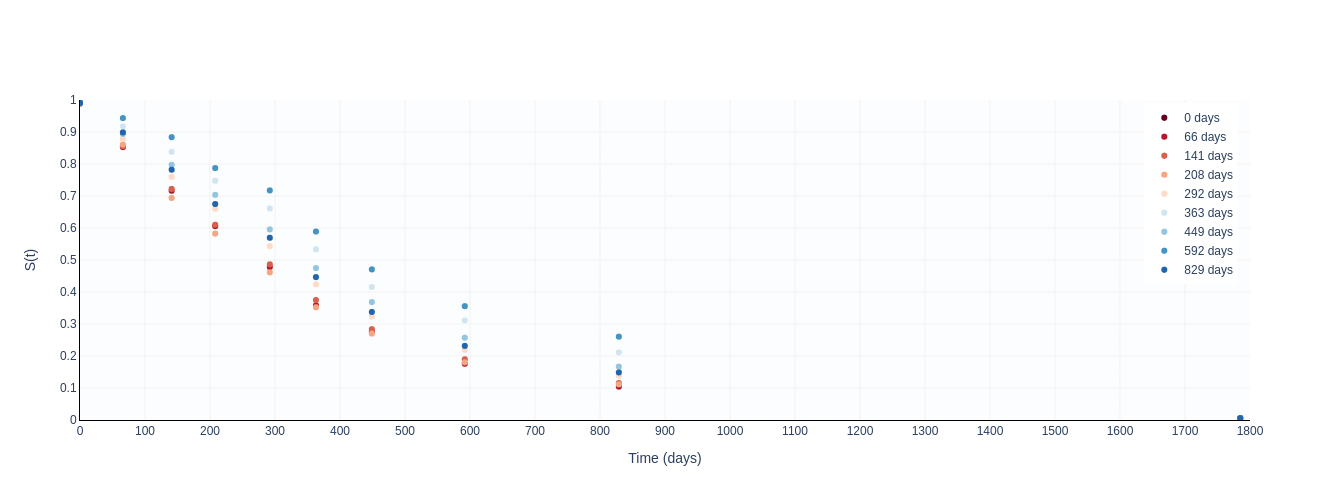

In [74]:
fig

# Evaluate

## Discrete

In [34]:
survs = dataset_2(dataset_filtered, phase='test', targets=True)[0][2]

Test Size: 204


In [82]:
ev = EvalSurv(surv_df, survs, events, 'km')

In [86]:
concordance = ev.concordance_td('antolini')
time_grid = np.linspace(0, survs.max())
# time_grid = np.linspace(0, 829)

integrated_brier_score = ev.integrated_brier_score(time_grid)

In [ ]:
integrated_brier_score

In [ ]:
concordance

In [57]:
brier_score = ev.brier_score(time_grid)

In [ ]:
ev.brier_score(time_grid)